In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)  #mengganti jumlah classifier sesuai output kelas

model_resnet = model_resnet.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model_resnet.fc.parameters(), lr=0.0001)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # transfoarms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
])

In [5]:
# Create an ImageFolder dataset
# Create ImageFolder datasets
train_dataset = ImageFolder(root='vegetable_images/train', transform=transform)
val_dataset = ImageFolder(root='vegetable_images/validation', transform=transform)
test_dataset = ImageFolder(root='vegetable_images/test', transform=transform)

# Create a data loader
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [7]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(15):  # loop over the dataset multiple times
    model_resnet.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(running_acc / len(train_loader))

    model_resnet.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)

            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))
    

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 0.89, Train Acc: 0.65, Val Loss: 0.63, Val Acc: 0.90
Epoch 2, Train Loss: 0.55, Train Acc: 0.91, Val Loss: 0.39, Val Acc: 0.97
Epoch 3, Train Loss: 0.37, Train Acc: 0.96, Val Loss: 0.27, Val Acc: 0.98
Epoch 4, Train Loss: 0.28, Train Acc: 0.97, Val Loss: 0.20, Val Acc: 0.99
Epoch 5, Train Loss: 0.22, Train Acc: 0.98, Val Loss: 0.15, Val Acc: 0.99
Epoch 6, Train Loss: 0.19, Train Acc: 0.98, Val Loss: 0.13, Val Acc: 0.99
Epoch 7, Train Loss: 0.16, Train Acc: 0.99, Val Loss: 0.11, Val Acc: 0.99
Epoch 8, Train Loss: 0.14, Train Acc: 0.99, Val Loss: 0.09, Val Acc: 0.99
Epoch 9, Train Loss: 0.12, Train Acc: 0.99, Val Loss: 0.08, Val Acc: 0.99
Epoch 10, Train Loss: 0.11, Train Acc: 0.99, Val Loss: 0.07, Val Acc: 0.99
Epoch 11, Train Loss: 0.10, Train Acc: 0.99, Val Loss: 0.06, Val Acc: 1.00
Epoch 12, Train Loss: 0.09, Train Acc: 0.99, Val Loss: 0.05, Val Acc: 1.00
Epoch 13, Train Loss: 0.08, Train Acc: 0.99, Val Loss: 0.05, Val Acc: 1.00
Epoch 14, Train Loss: 0.09, Train 

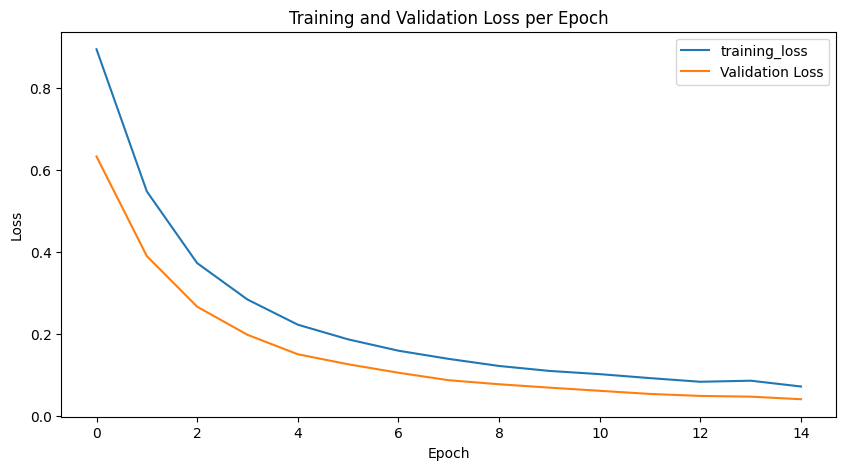

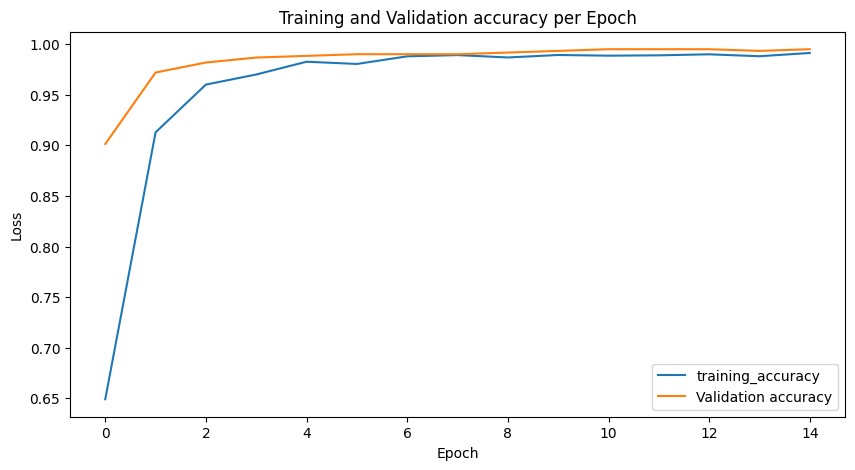

In [8]:
import matplotlib.pyplot as plt
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label = 'training_accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Validation F1 Score: 1.00


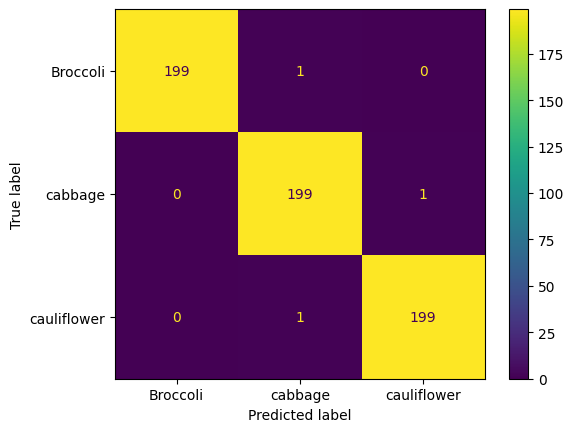

In [9]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return f1, cm

f1, cm = calculate_metrics(all_labels, all_preds)
print(f'Validation F1 Score: {f1:.2f}')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Broccoli',  "cabbage", "cauliflower"] )
disp.plot()
plt.show()

In [10]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=['Broccoli',  "cabbage", "cauliflower"])
print(report)

              precision    recall  f1-score   support

    Broccoli       1.00      0.99      1.00       200
     cabbage       0.99      0.99      0.99       200
 cauliflower       0.99      0.99      0.99       200

    accuracy                           0.99       600
   macro avg       1.00      0.99      1.00       600
weighted avg       1.00      0.99      1.00       600



In [11]:
# torch.save(model_resnet.state_dict(), 'transfer_learning_resnet.pth')  #save the model has been trained